# Identifying galaxies matched to multiple clusters in the Tully Catalog

Here, we will look at the overlapping objects between different clusters in the Tully catalog.

In [1]:
import requests

from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c
from PIL import Image

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from z_CMB_convert import convert_z_frame

In [2]:
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

## Read in calibration sample of galaxies and the cluster catalog

In [3]:
# Read in the table of galaxies that have been put into clusters

SGA = Table.read('SGA-2020_jura_Vrot_cluster_calib_VI_Tully_full.fits')
SGA['SGA_ID'] = SGA['SGA_ID'].astype(int) #for some reason they save as floats, so fix this

print(len(SGA), 'total gals in calibration sample.')
SGA[:5]

1101 total gals in calibration sample.


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,PHOTSYS,V_0p4R26,V_0p4R26_err,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,CLUSTER_ID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,,,,,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,bytes1,float64,float64,float64,float64,float64,bytes10,float64,float64,float64,float64,float64,float64,int64
761,SGA-2020 761,PGC2124331,2124331,245.779107,38.3412843,S?,126.35,0.37931496,0.38282475,0.02875189,24.266481,17.743,False,LEDA-20181114,215,PGC2124331,1,True,245.779107,38.3412843,0.37931496,2458p382,245.77910514417866,38.34129902721367,0.658071,SB26,124.564224,0.32319182,245.7790024718725,38.34136650665185,13.053121,6.714251,6.2390046,5.84362,6.4117727,8.609017,10.602186,11.909309,13.033529,14.184758,15.220757,17.676575,19.74213,18.026365,17.18771,16.650698,17.702948,16.875063,16.343647,17.507347,16.688942,16.16051,17.413507,16.596327,16.079664,17.34833,16.55872,16.053045,17.303328,16.517853,16.030941,17.284056,16.503609,16.020493,17.248598,16.482084,16.005566,17.234013,16.470325,15.999225,0.10197908,0.13490468,0.25322494,0.17365545,0.10943003,0.12833115,0.21649462,0.27748483,0.18866985,0.053782266,0.058268037,0.061345633,0.04634789,0.05001401,0.052562416,0.04191638,0.045257825,0.04746368,0.039738998,0.04284585,0.045189332,0.03820397,0.041750528,0.044285223,0.037093215,0.04056332,0.043528788,0.03

## Read in the (modified) Tully Catalog

In [4]:
clusters_T = Table.read('../Tully15-Table3.fits')

# Convert Tully's central cluster velocities to heliocentric frame (to match the DESI redshift frame)
cls_coords = SkyCoord(clusters_T['SGLON'], clusters_T['SGLAT'], unit='deg', frame='supergalactic').icrs
z_hel = convert_z_frame(clusters_T['<Vcmba>']/c.c.to('km/s'), cls_coords.ra.deg, cls_coords.dec.deg, corrtype='-full')
clusters_T['HRV'] = z_hel*c_kms

clusters_K = Table.read('../Kourkchi17-Table2.fits.gz')

# Rename columns to match Tully's catalog
clusters_K['Nm'].name = 'Nmb'
clusters_K['sigmaL'].name = 'sigP'
clusters_K['sigmaV'].name = 'sigV'

# Convert from distance to distance modulus
clusters_K['DM'] = 5*np.log10(clusters_K['Dist'].value) + 25

# Define NestID
clusters_K['Nest'] = np.char.add('3', clusters_K['PGC1'].astype('str')).astype('int')

/tmp/ipykernel_1083954/510280904.py:16: RuntimeWarning: divide by zero encountered in log10
  clusters_K['DM'] = 5*np.log10(clusters_K['Dist'].value) + 25


In [5]:
K_keep = np.ones(len(clusters_T), dtype=bool)

for i in range(len(clusters_K)):
    K_keep = K_keep & (clusters_T['PGC1'] != clusters_K['PGC1'][i])

clusters_all = vstack([clusters_T[K_keep], clusters_K])

catalog = clusters_all['Nest', 'Nmb', 'PGC1', 'SGLON', 'SGLAT', 'DM', 'sigV', 'sigP', 'R2t', 'HRV'][clusters_all['Nmb'] >= 5]


## Identify galaxies matched to multiple clusters

In [6]:
unique, counts = np.unique(SGA['SGA_ID'], return_counts=True)

dups = unique[counts > 1]
print(len(dups), 'galaxies assigned to more than 1 cluster.')
duplicates = SGA[np.isin(SGA['SGA_ID'], dups)]
duplicates.sort('SGA_ID')
duplicates['SGA_ID', 'CLUSTER_ID']

82 galaxies assigned to more than 1 cluster.


SGA_ID,CLUSTER_ID
int64,int64
761,100004
761,100110
7511,100041
7511,100110
8508,340001
8508,341220
11814,100110
11814,100004
32760,100110


In [7]:
tot_clusters, cts = np.unique(SGA['CLUSTER_ID'], return_counts=True)
len(tot_clusters)

33

In [8]:
### Return a list of how many galaxies in each cluster are overlaps

unique, counts = np.unique(duplicates['CLUSTER_ID'], return_counts=True)

cluster_probs = unique[counts > 1]

for cluster, count in zip(cluster_probs, counts[counts > 1]):
    print(f"Cluster ID: {cluster}, Count: {count}")

Cluster ID: 100004, Count: 41
Cluster ID: 100041, Count: 7
Cluster ID: 100046, Count: 3
Cluster ID: 100049, Count: 4
Cluster ID: 100067, Count: 4
Cluster ID: 100070, Count: 20
Cluster ID: 100081, Count: 7
Cluster ID: 100110, Count: 24
Cluster ID: 100137, Count: 7
Cluster ID: 100302, Count: 4
Cluster ID: 340001, Count: 16
Cluster ID: 341220, Count: 23
Cluster ID: 341789, Count: 15


In [9]:
# ##### Plot where these bad clusters fall on the map


# # nest_ids = np.asarray(list(sga_clusters.keys()))
# idx = np.in1d(clusters['Nest'], cluster_probs)
# cluster_lon = clusters['SGLON'][idx]
# cluster_lat = clusters['SGLAT'][idx]
# cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

# fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
# for coord in cluster_coords:
#     _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
#     _dec = np.radians(coord.transform_to('icrs').dec)
#     ax.plot(_ra, _dec, 'kx', ms=10, mew=2)
    

# ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
# ax.grid(ls=':');

# # fig.savefig('Figures/TF_Y3_SGA_Vrot_clusters.png', dpi=150);

## Make a list of which clusters are overlapping with each other

In [10]:
cluster_overlap = {}
overlap_sets = set()  # To store unique unordered pairs of overlapping clusters, so everything is not plotted twice

for galaxy_id in np.unique(duplicates['SGA_ID']):
    galaxy_rows = duplicates[duplicates['SGA_ID'] == galaxy_id]
    
    # Get the list of clusters this galaxy belongs to
    clusters = list(galaxy_rows['CLUSTER_ID'])
    
    # For each cluster, add the others this galaxy belongs to
    for cluster in clusters:
        if cluster not in cluster_overlap:
            cluster_overlap[cluster] = set()
        cluster_overlap[cluster].update([c for c in clusters if c != cluster])
    
    # Store the unique pair
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            pair = tuple(sorted((clusters[i], clusters[j])))
            overlap_sets.add(pair)


for cluster_id, overlaps in cluster_overlap.items():
    print(f"Cluster {cluster_id} overlaps with clusters: {sorted(list(overlaps))}")

overlap_pairs = list(overlap_sets)


Cluster 100004 overlaps with clusters: [100041, 100070, 100110]
Cluster 100110 overlaps with clusters: [100004, 100041]
Cluster 100041 overlaps with clusters: [100004, 100110]
Cluster 340001 overlaps with clusters: [341220, 341789]
Cluster 341220 overlaps with clusters: [340001, 341789]
Cluster 100070 overlaps with clusters: [100004]
Cluster 341789 overlaps with clusters: [340001, 341220]
Cluster 100137 overlaps with clusters: [100081]
Cluster 100081 overlaps with clusters: [100137]
Cluster 100046 overlaps with clusters: [100067]
Cluster 100067 overlaps with clusters: [100046, 100135]
Cluster 100135 overlaps with clusters: [100067]
Cluster 100302 overlaps with clusters: [100049]
Cluster 100049 overlaps with clusters: [100302]


## Make plots of the overlapping clusters

In [11]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [12]:
def plot_double_cluster_members(cluster_cat, cluster_id_1, cluster_id_2, sgacat, sga_ids1, sga_ids2):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx_1 = np.in1d(cluster_cat['Nest'], cluster_id_1)
    cluster_lon_1 = cluster_cat['SGLON'][idx_1][0]
    cluster_lat_1 = cluster_cat['SGLAT'][idx_1][0]
    cluster_mu_1 = cluster_cat['DM'][idx_1][0]
    cluster_dist_1 = 10 * 10**(0.2*cluster_mu_1) * 1e-6
    cluster_v_1 = H0*cluster_dist_1
    cluster_sigma_1 = cluster_cat['sigP'][idx_1][0]
    cluster_R2t_1 = cluster_cat['R2t'][idx_1][0]
    cluster_R2t_1p5_1 = np.arctan(1.5*cluster_R2t_1 / (cluster_v_1/H0)) * u.radian
    cluster_R2t_3_1 = np.arctan(3*cluster_R2t_1 / (cluster_v_1/H0)) * u.radian
    cluster_R2t_4_1 = np.arctan(4*cluster_R2t_1 / (cluster_v_1/H0)) * u.radian
    
    idx_2 = np.in1d(cluster_cat['Nest'], cluster_id_2)
    cluster_lon_2 = cluster_cat['SGLON'][idx_2][0]
    cluster_lat_2 = cluster_cat['SGLAT'][idx_2][0]
    cluster_mu_2 = cluster_cat['DM'][idx_2][0]
    cluster_dist_2 = 10 * 10**(0.2*cluster_mu_2) * 1e-6
    cluster_v_2 = H0*cluster_dist_2
    cluster_sigma_2 = cluster_cat['sigP'][idx_2][0]
    cluster_R2t_2 = cluster_cat['R2t'][idx_2][0]
    cluster_R2t_1p5_2 = np.arctan(1.5*cluster_R2t_2 / (cluster_v_2/H0)) * u.radian
    cluster_R2t_3_2 = np.arctan(3*cluster_R2t_2 / (cluster_v_2/H0)) * u.radian
    cluster_R2t_4_2 = np.arctan(4*cluster_R2t_2 / (cluster_v_2/H0)) * u.radian
    
    
    cluster_coord_1 = SkyCoord(cluster_lon_1, cluster_lat_1, unit='deg', frame='supergalactic').transform_to('icrs')
    cluster_coord_2 = SkyCoord(cluster_lon_2, cluster_lat_2, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord_1)
    print(f'{cluster_v_1} +/- {cluster_sigma_1} km/s')
    
    print(cluster_coord_2)
    print(f'{cluster_v_2} +/- {cluster_sigma_2} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx_1 = np.in1d(sgacat['SGA_ID'], sga_ids1)
    z_sga_1 = sgacat['Z_DESI'][idx_1]
    z_sorted_1 = np.sort(z_sga_1)
    ngal_1 = len(z_sorted_1)
    z_sga_median_1 = np.mean(z_sorted_1[ngal_1//2:ngal_1//2 + 2]) if (ngal_1 % 2 == 0) else z_sorted_1[ngal_1//2]
    
    sga_coords_1 = SkyCoord(ra=sgacat['RA'][idx_1], dec=sgacat['DEC'][idx_1], unit='deg', frame='icrs')
    sga_coords_median_1 = cluster_median_coords(sga_coords_1)

    idx_2 = np.in1d(sgacat['SGA_ID'], sga_ids2)
    z_sga_2 = sgacat['Z_DESI'][idx_2]
    z_sorted_2 = np.sort(z_sga_2)
    ngal_2 = len(z_sorted_2)
    z_sga_median_2 = np.mean(z_sorted_2[ngal_2//2:ngal_2//2 + 2]) if (ngal_2 % 2 == 0) else z_sorted_2[ngal_2//2]
    
    sga_coords_2 = SkyCoord(ra=sgacat['RA'][idx_2], dec=sgacat['DEC'][idx_2], unit='deg', frame='icrs')
    sga_coords_median_2 = cluster_median_coords(sga_coords_2)
    
    
    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord_1, radius=cluster_R2t_4_1+cluster_R2t_4_2)
    ax.grid()

    ax.plot(sga_coords_1.ra.deg, sga_coords_1.dec.deg, 'bo', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median_1.ra.deg, sga_coords_median_1.dec.deg, 'bD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_1.ra.deg, cluster_coord_1.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)
    
    ax.plot(sga_coords_2.ra.deg, sga_coords_2.dec.deg, 'ro', transform=ax.get_transform('world'), alpha=0.3, label=f'{cluster_id}')
    ax.plot(sga_coords_median_2.ra.deg, sga_coords_median_2.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_2.ra.deg, cluster_coord_2.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)
    
    # ax.plot(sga_coords_3.ra.deg, sga_coords_3.dec.deg, 'go', transform=ax.get_transform('world'), alpha=0.5)
    
    inner_1 = SphericalCircle(cluster_coord_1, cluster_R2t_1p5_1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_1)

    outer_1 = SphericalCircle(cluster_coord_1, cluster_R2t_3_1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer_1)    
    

    inner_2 = SphericalCircle(cluster_coord_2, cluster_R2t_1p5_2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_2)

    outer_2 = SphericalCircle(cluster_coord_2, cluster_R2t_3_2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='solid', facecolor='none')
    ax.add_patch(outer_2)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    
    ax.plot(z_sga_1, sga_coords_1.dec.deg, 'bo', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median_1, sga_coords_median_1.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v_1/c_kms, cluster_coord_1.dec.deg, 'kx', ms=10, mew=5)

    decmin_1 = np.min(sga_coords_1.dec.deg) - 0.5
    decmax_1 = np.max(sga_coords_1.dec.deg) + 0.5
    
    ax.plot(z_sga_2, sga_coords_2.dec.deg, 'ro', alpha=0.3, label=f'{cluster_id}')
    ax.plot(z_sga_median_2, sga_coords_median_2.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v_2/c_kms, cluster_coord_2.dec.deg, 'kx', ms=10, mew=5)

    decmin_2 = np.min(sga_coords_2.dec.deg) - 0.5
    decmax_2 = np.max(sga_coords_2.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v_1-3*cluster_sigma_1,
                          cluster_v_1+3*cluster_sigma_1,
                          cluster_v_1-2*cluster_sigma_1,
                          cluster_v_1+2*cluster_sigma_1,])/c_kms,
                          decmin_1, decmax_1,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])    

    
    ax.vlines(np.asarray([cluster_v_2-3*cluster_sigma_2,
                          cluster_v_2+3*cluster_sigma_2,
                          cluster_v_2-2*cluster_sigma_2,
                          cluster_v_2+2*cluster_sigma_2])/c_kms,
                          decmin_2, decmax_2,
              colors='tab:red',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])      
    
    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(min(decmin_1, decmin_2), max(decmax_1,decmax_2)))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords_1.ra.deg, z_sga_1, 'bo', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median_1.ra.deg, z_sga_median_1, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord_1.ra.deg, cluster_v_1/c_kms, 'kx', ms=10, mew=5)

    ramin_1 = np.min(sga_coords_1.ra.deg) - 0.5
    ramax_1 = np.max(sga_coords_1.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v_1-3*cluster_sigma_1,
                          cluster_v_1+3*cluster_sigma_1,
                          cluster_v_1-2*cluster_sigma_1,
                          cluster_v_1+2*cluster_sigma_1])/c_kms,
              ramin_1, ramax_1,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.plot(sga_coords_2.ra.deg, z_sga_2, 'ro', alpha=0.3, label=f'{cluster_id}')
    ax.plot(sga_coords_median_2.ra.deg, z_sga_median_2, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord_2.ra.deg, cluster_v_2/c_kms, 'kx', ms=10, mew=5)

    ramin_2 = np.min(sga_coords_2.ra.deg) - 0.5
    ramax_2 = np.max(sga_coords_2.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v_2-3*cluster_sigma_2,
                          cluster_v_2+3*cluster_sigma_2,
                          cluster_v_2-2*cluster_sigma_2,
                          cluster_v_2+2*cluster_sigma_2])/c_kms,
              ramin_2, ramax_2,
              colors='tab:red',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])    
    
    
    
    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(max(ramax_1, ramax_2), min(ramin_1,ramin_2)))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    fig.suptitle(f'TF Jura Observations of Clusters {cluster_id_1} and {cluster_id_2}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (244.29362068, 35.02777805)>
9418.895965228417 +/- 627 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (245.46482264, 37.76598219)>
9727.47223776964 +/- 565 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (227.93611812, 7.39421399)>
14125.375446227554 +/- 835 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (246.98584602, 40.22479396)>
9418.895965228417 +/- 1057 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (245.46482264, 37.76598219)>
9727.47223776964 +/- 565 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (185.6306334, 4.81896863)>
1699.0000000000023 +/- 151 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (187.75580155, 12.40596574)>
1575.9999999999986 +/- 610 km/s
<SkyCoord (

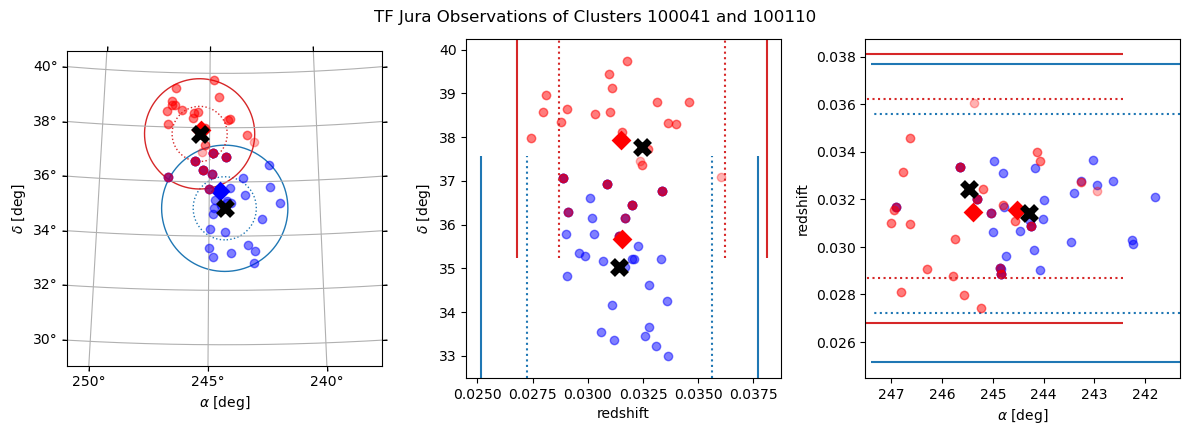

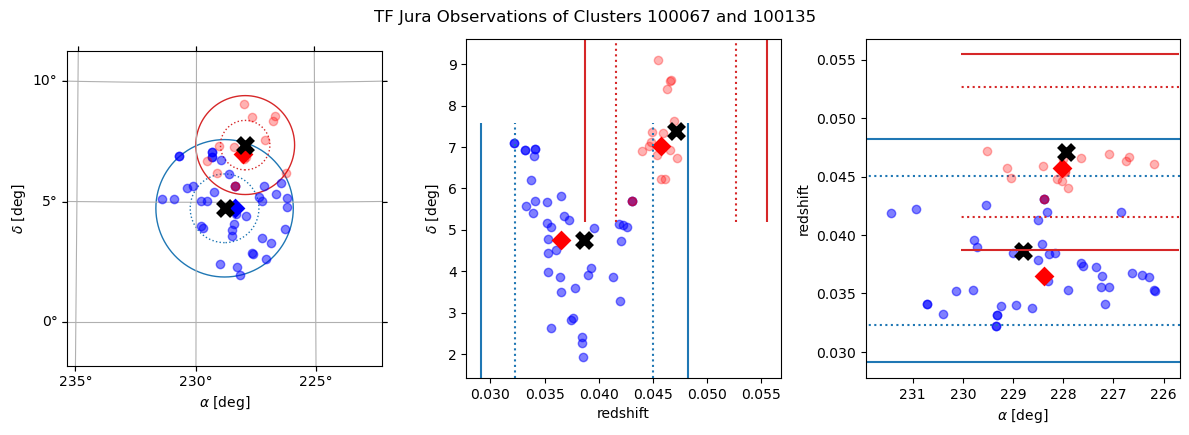

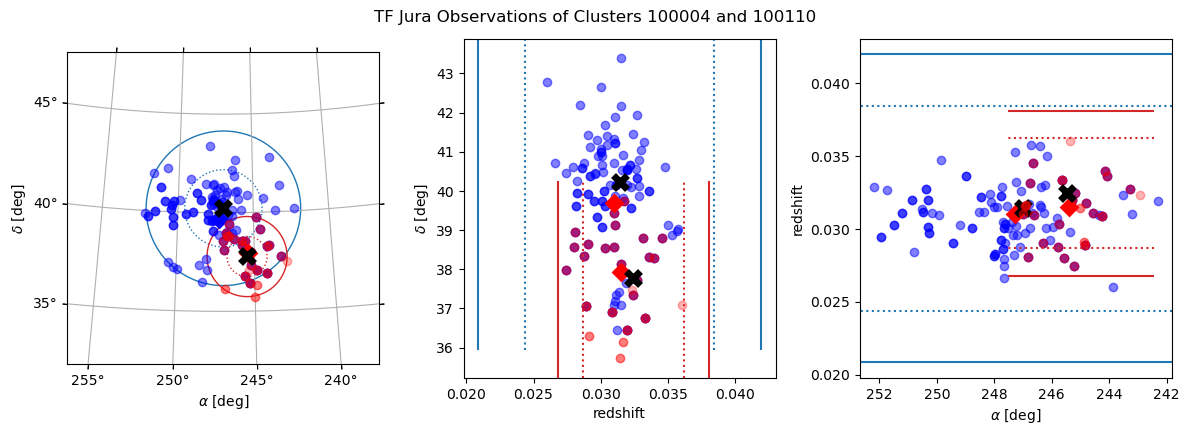

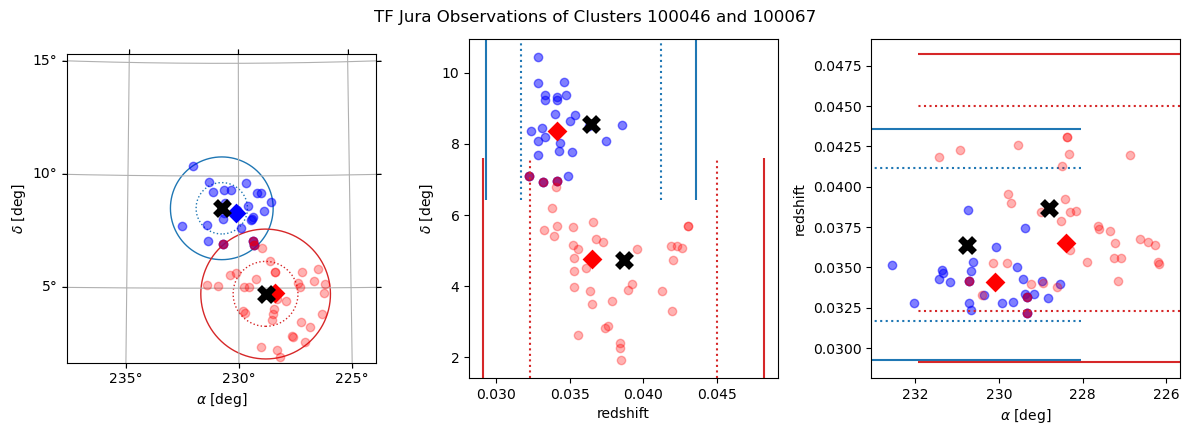

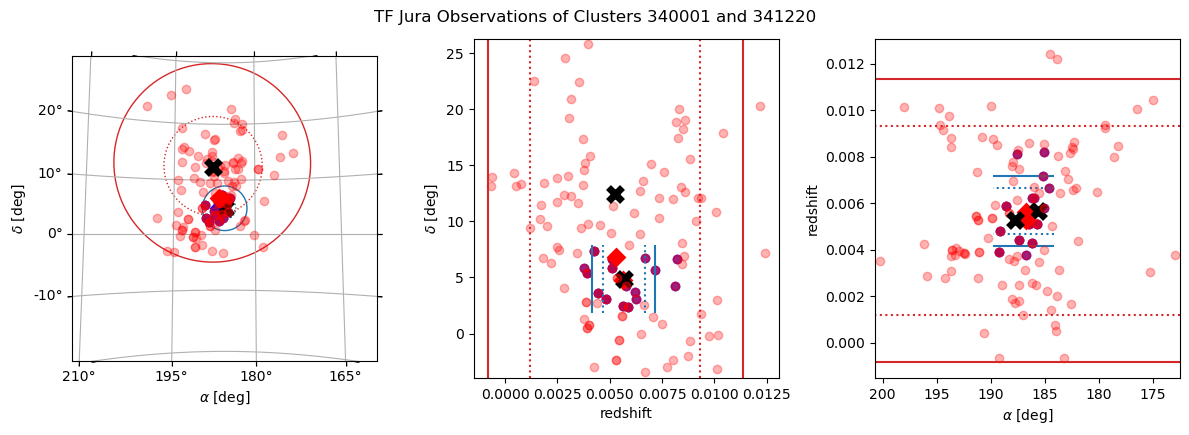

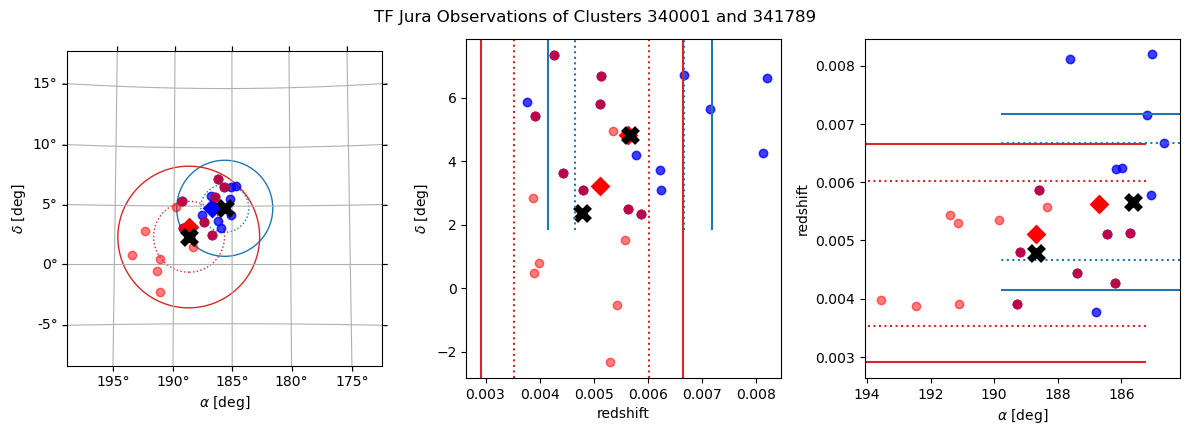

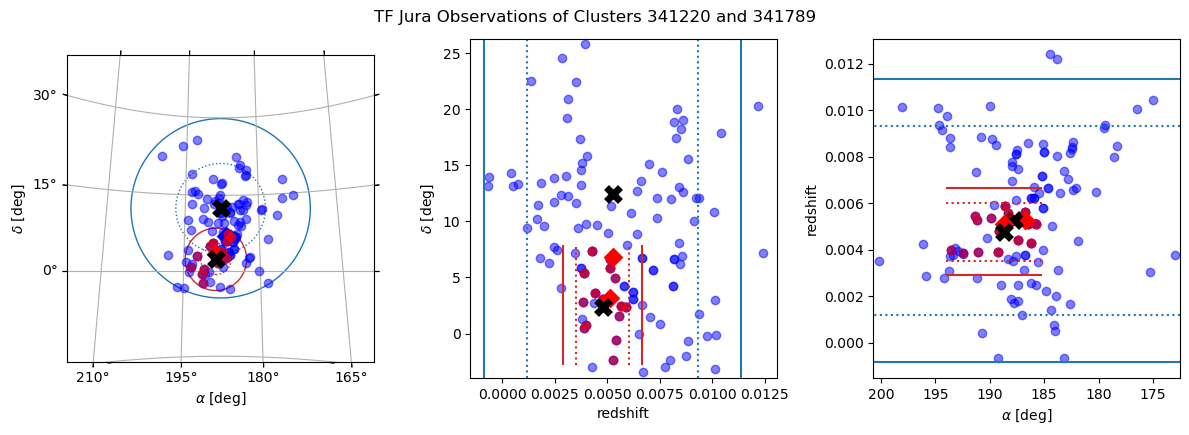

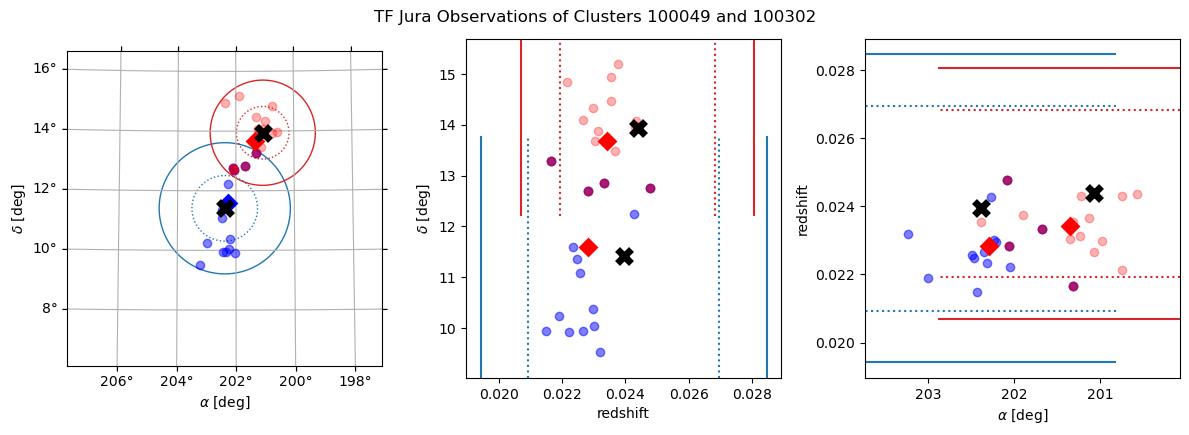

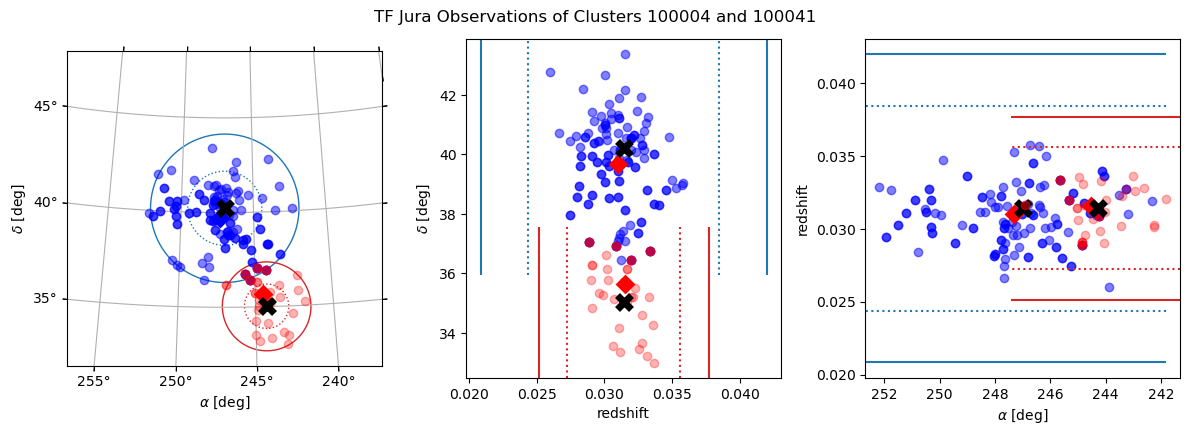

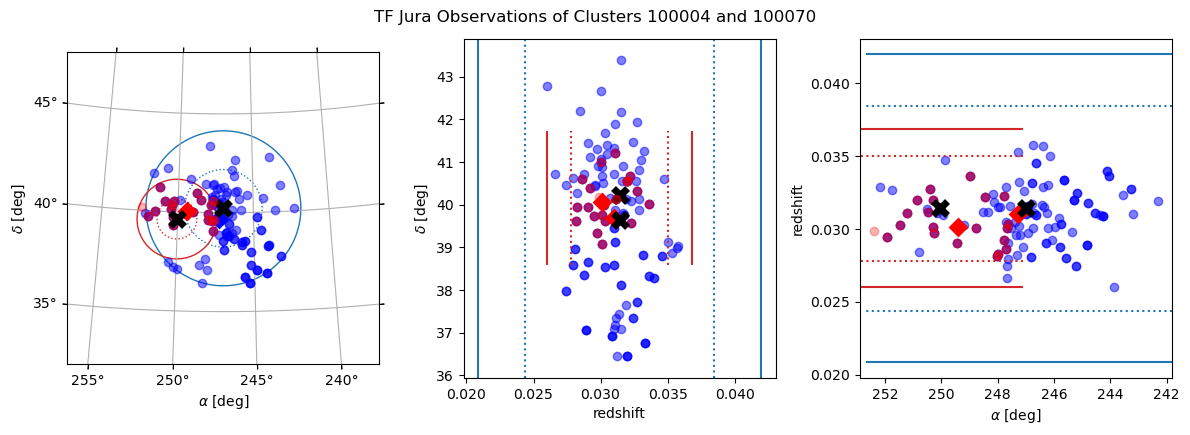

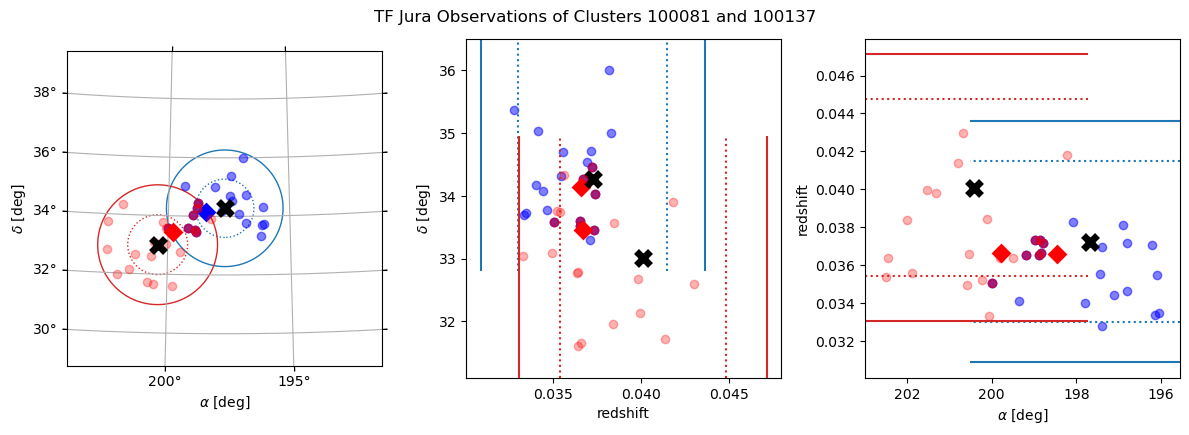

In [13]:
i=0
while i < len(overlap_pairs):
    id1 = overlap_pairs[i][0]
    id2 = overlap_pairs[i][1]
    sga_1 = SGA[SGA['CLUSTER_ID']==id1]
    sga_2 = SGA[SGA['CLUSTER_ID']==id2]
    
    fig = plot_double_cluster_members(catalog, id1, id2, SGA, sga_1['SGA_ID'], sga_2['SGA_ID'])
    fig.savefig(f'Figures/TF_Y3_cluster_overlap_{id1}_{id2}', dpi=150);
    i+=1

### Plot 3 clusters on top of each other for the more extreme overlaps

In [14]:
def plot_triple_cluster_members(clusters, cluster_id_1, cluster_id_2, cluster_id_3, sgacat, sga_ids1, sga_ids2, sga_ids3):
    """Generate a set of diagnostic plots for the members of three clusters."""
    
    #- Get cluster sky coordinates and properties for cluster 1, 2, and 3
    def get_cluster_properties(cluster_id):
        idx = np.in1d(clusters['Nest'], cluster_id)
        cluster_lon = clusters['SGLON'][idx][0]
        cluster_lat = clusters['SGLAT'][idx][0]
        cluster_mu = clusters['DM'][idx][0]
        cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
        cluster_v = H0 * cluster_dist
        cluster_sigma = clusters['sigP'][idx][0]
        cluster_R2t = clusters['R2t'][idx][0]
        cluster_R2t_1p5 = np.arctan(1.5 * cluster_R2t / (cluster_v / H0)) * u.radian
        cluster_R2t_3 = np.arctan(3 * cluster_R2t / (cluster_v / H0)) * u.radian
        cluster_R2t_4 = np.arctan(4 * cluster_R2t / (cluster_v / H0)) * u.radian
        return cluster_lon, cluster_lat, cluster_mu, cluster_v, cluster_sigma, cluster_R2t, cluster_R2t_1p5, cluster_R2t_3, cluster_R2t_4

    # Get properties for all three clusters
    cluster_data_1 = get_cluster_properties(cluster_id_1)
    cluster_data_2 = get_cluster_properties(cluster_id_2)
    cluster_data_3 = get_cluster_properties(cluster_id_3)
    
    # Unpack the cluster data
    cluster_lon_1, cluster_lat_1, cluster_mu_1, cluster_v_1, cluster_sigma_1, cluster_R2t_1, cluster_R2t_1p5_1, cluster_R2t_3_1, cluster_R2t_4_1 = cluster_data_1
    cluster_lon_2, cluster_lat_2, cluster_mu_2, cluster_v_2, cluster_sigma_2, cluster_R2t_2, cluster_R2t_1p5_2, cluster_R2t_3_2, cluster_R2t_4_2 = cluster_data_2
    cluster_lon_3, cluster_lat_3, cluster_mu_3, cluster_v_3, cluster_sigma_3, cluster_R2t_3, cluster_R2t_1p5_3, cluster_R2t_3_3, cluster_R2t_4_3 = cluster_data_3
    
    # Get cluster sky coordinates (ICRS frame)
    cluster_coord_1 = SkyCoord(cluster_lon_1, cluster_lat_1, unit='deg', frame='supergalactic').transform_to('icrs')
    cluster_coord_2 = SkyCoord(cluster_lon_2, cluster_lat_2, unit='deg', frame='supergalactic').transform_to('icrs')
    cluster_coord_3 = SkyCoord(cluster_lon_3, cluster_lat_3, unit='deg', frame='supergalactic').transform_to('icrs')

    # Get SGA galaxy coordinates and median redshift for each cluster
    def get_sga_coords_and_median_redshift(sga_ids):
        idx = np.in1d(sgacat['SGA_ID'], sga_ids)
        z_sga = sgacat['Z_DESI'][idx]
        z_sorted = np.sort(z_sga)
        ngal = len(z_sorted)
        z_median = np.mean(z_sorted[ngal // 2: ngal // 2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal // 2]
        sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
        sga_coords_median = cluster_median_coords(sga_coords)
        return z_sga, sga_coords, sga_coords_median, z_median
    
    z_sga_1, sga_coords_1, sga_coords_median_1, z_sga_median_1 = get_sga_coords_and_median_redshift(sga_ids1)
    z_sga_2, sga_coords_2, sga_coords_median_2, z_sga_median_2 = get_sga_coords_and_median_redshift(sga_ids2)
    z_sga_3, sga_coords_3, sga_coords_median_3, z_sga_median_3 = get_sga_coords_and_median_redshift(sga_ids3)
    
    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(15,10), tight_layout=True)
    
    # First plot: Cluster sky coordinates
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord_1, radius=(cluster_R2t_4_1 + cluster_R2t_4_2 + cluster_R2t_4_3)*0.6)
    ax.grid()

    # Cluster 1 (blue), Cluster 2 (red), Cluster 3 (green)
    ax.plot(sga_coords_1.ra.deg, sga_coords_1.dec.deg, 'bo', transform=ax.get_transform('world'), alpha=0.5, label=f'Cluster {cluster_id_1}')
    ax.plot(sga_coords_median_1.ra.deg, sga_coords_median_1.dec.deg, 'bD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_1.ra.deg, cluster_coord_1.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    ax.plot(sga_coords_2.ra.deg, sga_coords_2.dec.deg, 'ro', transform=ax.get_transform('world'), alpha=0.3, label=f'Cluster {cluster_id_2}')
    ax.plot(sga_coords_median_2.ra.deg, sga_coords_median_2.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_2.ra.deg, cluster_coord_2.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    ax.plot(sga_coords_3.ra.deg, sga_coords_3.dec.deg, 'go', transform=ax.get_transform('world'), alpha=0.3, label=f'Cluster {cluster_id_3}')
    ax.plot(sga_coords_median_3.ra.deg, sga_coords_median_3.dec.deg, 'gD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_3.ra.deg, cluster_coord_3.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)
    
    inner_1 = SphericalCircle(cluster_coord_1, cluster_R2t_1p5_1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_1)
    
    outer_1 = SphericalCircle(cluster_coord_1, cluster_R2t_3_1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer_1)
    
    inner_2 = SphericalCircle(cluster_coord_2, cluster_R2t_1p5_2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_2)
    
    outer_2 = SphericalCircle(cluster_coord_2, cluster_R2t_3_2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='solid', facecolor='none')
    ax.add_patch(outer_2)
    
    inner_3 = SphericalCircle(cluster_coord_3, cluster_R2t_1p5_3, transform=ax.get_transform('world'), edgecolor='tab:green', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_3)
    
    outer_3 = SphericalCircle(cluster_coord_3, cluster_R2t_3_3, transform=ax.get_transform('world'), edgecolor='tab:green', linestyle='solid', facecolor='none')
    ax.add_patch(outer_3)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]', title = f'Clusters: {cluster_id_1}, {cluster_id_2}, {cluster_id_3}')
    
    


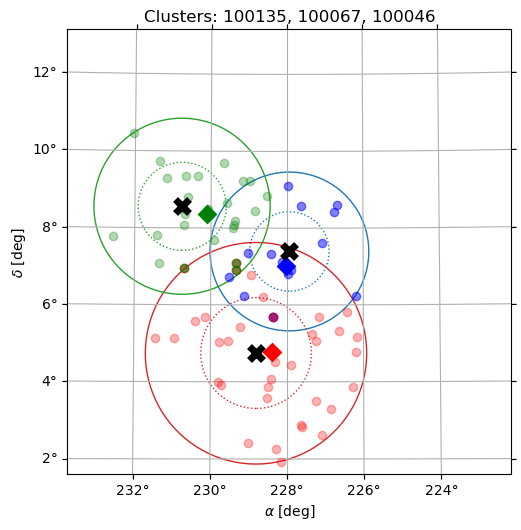

In [15]:
sga_1 = SGA[SGA['CLUSTER_ID']==100135]
sga_2 = SGA[SGA['CLUSTER_ID']==100067]
sga_3 = SGA[SGA['CLUSTER_ID']==100046]

plot_triple_cluster_members(catalog, 100135, 100067, 100046, SGA, sga_1['SGA_ID'], sga_2['SGA_ID'], sga_3['SGA_ID'])

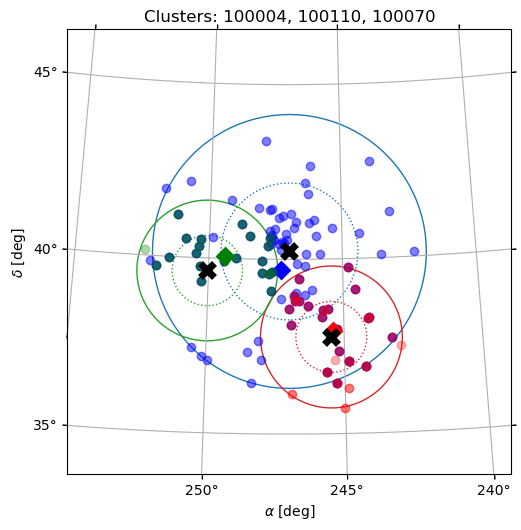

In [16]:
# 100067 overlaps with clusters: [100046, 100135]
sga_1 = SGA[SGA['CLUSTER_ID']==100004]
sga_2 = SGA[SGA['CLUSTER_ID']==100110]
sga_3 = SGA[SGA['CLUSTER_ID']==100070]

plot_triple_cluster_members(catalog, 100004, 100110, 100070, SGA, sga_1['SGA_ID'], sga_2['SGA_ID'], sga_3['SGA_ID'])

## Save a list of all of the clusters that are overlapping
We will save a text file with a list of all of these clusters, so that we can exclude them from our analysis.

In [17]:
np.savetxt('Tully_overlaps.txt', cluster_probs.astype(int) , fmt='%d')